c:\Users\furaf\anaconda3\envs\ad\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [1/10], Loss: 0.2356
Epoch [2/10], Loss: 0.2044
Epoch [3/10], Loss: 0.1746
Epoch [4/10], Loss: 0.1232
Epoch [5/10], Loss: 0.0862
Epoch [6/10], Loss: 0.0663
Epoch [7/10], Loss: 0.0462
Epoch [8/10], Loss: 0.0455
Epoch [9/10], Loss: 0.0395
Epoch [10/10], Loss: 0.0353
学習完了！

--- A. 再構成結果の比較 ---


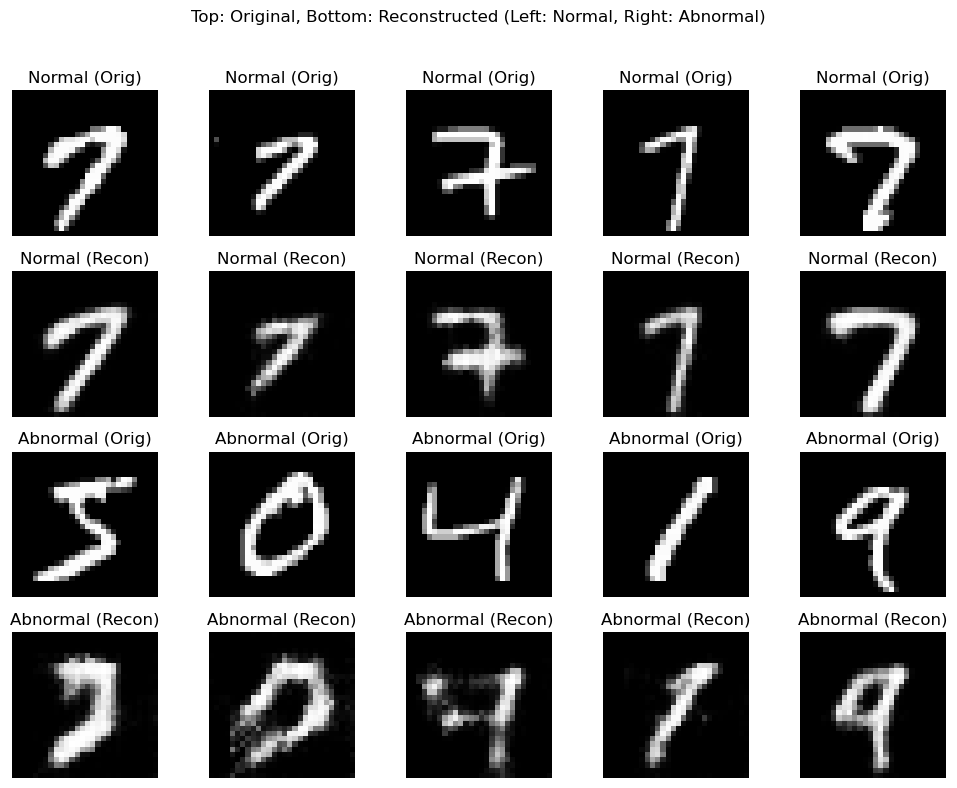


--- B. 潜在空間の可視化 ---


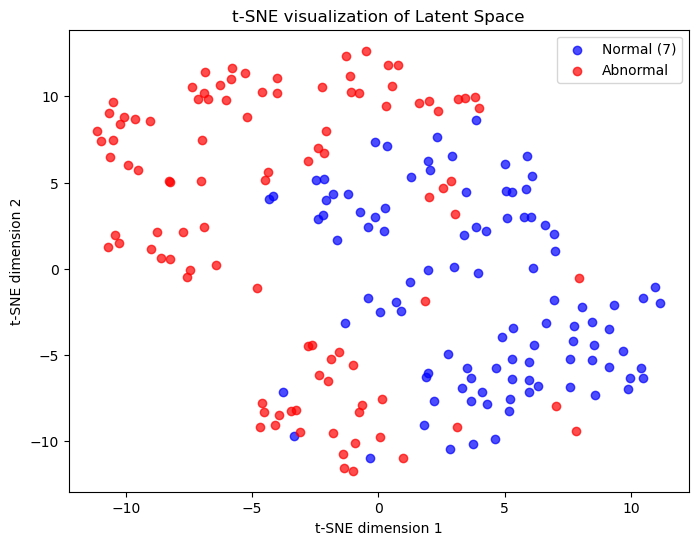


--- C. 判断根拠の可視化 ---


C:\Users\furaf\captum\captum\attr\_core\saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from captum.attr import Saliency

# 1. データセットの準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# MNISTデータセットをダウンロード
full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 数字'7'を正常、その他を異常とする
normal_class = 7
normal_indices = [i for i, (img, label) in enumerate(full_dataset) if label == normal_class]
abnormal_indices = [i for i, (img, label) in enumerate(full_dataset) if label != normal_class]

# 正常データのみで学習データローダーを作成
train_dataset = Subset(full_dataset, normal_indices)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# テスト用に正常・異常データを少量用意
test_normal_dataset = Subset(full_dataset, normal_indices[:100])
test_abnormal_dataset = Subset(full_dataset, abnormal_indices[:100])
test_loader = DataLoader(torch.utils.data.ConcatDataset([test_normal_dataset, test_abnormal_dataset]), batch_size=1, shuffle=True)


# 2. モデルの構築 (CNNオートエンコーダ)
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # エンコーダ
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # -> 16x14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # -> 32x7x7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7) # -> 64x1x1 (これが潜在空間)
        )
        # デコーダ
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), # -> 32x7x7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # -> 16x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), # -> 1x28x28
            nn.Tanh() # 出力範囲を-1~1に
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

# 3. 学習
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder().to(device)
criterion = nn.MSELoss() # 再構成誤差としてMean Squared Errorを使用
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)

        # 順伝播
        recon, _ = model(img)
        loss = criterion(recon, img)

        # 逆伝播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("学習完了！")


# 4. 可視化と解釈
model.eval()

# A. 再構成誤差の比較
print("\n--- A. 再構成結果の比較 ---")
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
fig.suptitle("Top: Original, Bottom: Reconstructed (Left: Normal, Right: Abnormal)")
# 正常データ
for i in range(5):
    img, _ = test_normal_dataset[i]
    img = img.unsqueeze(0).to(device)
    recon, _ = model(img)

    axes[0, i].imshow(img.cpu().squeeze().numpy(), cmap='gray')
    axes[0, i].set_title("Normal (Orig)")
    axes[0, i].axis('off')
    axes[1, i].imshow(recon.cpu().detach().squeeze().numpy(), cmap='gray')
    axes[1, i].set_title("Normal (Recon)")
    axes[1, i].axis('off')

# 異常データ
for i in range(5):
    img, _ = test_abnormal_dataset[i]
    img = img.unsqueeze(0).to(device)
    recon, _ = model(img)

    axes[2, i].imshow(img.cpu().squeeze().numpy(), cmap='gray')
    axes[2, i].set_title("Abnormal (Orig)")
    axes[2, i].axis('off')
    axes[3, i].imshow(recon.cpu().detach().squeeze().numpy(), cmap='gray')
    axes[3, i].set_title("Abnormal (Recon)")
    axes[3, i].axis('off')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# B. 潜在空間の可視化 (t-SNE)
print("\n--- B. 潜在空間の可視化 ---")
latents = []
labels = []
with torch.no_grad():
    for img, label in DataLoader(torch.utils.data.ConcatDataset([test_normal_dataset, test_abnormal_dataset]), batch_size=64):
        img = img.to(device)
        _, latent = model(img)
        latents.append(latent.cpu().view(latent.size(0), -1))
        # 正常(7)なら1, 異常なら0
        labels.append((label == normal_class).long())

latents = torch.cat(latents).numpy()
labels = torch.cat(labels).numpy()

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latents_2d = tsne.fit_transform(latents)

plt.figure(figsize=(8, 6))
plt.scatter(latents_2d[labels==1, 0], latents_2d[labels==1, 1], c='blue', label='Normal (7)', alpha=0.7)
plt.scatter(latents_2d[labels==0, 0], latents_2d[labels==0, 1], c='red', label='Abnormal', alpha=0.7)
plt.title('t-SNE visualization of Latent Space')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend()
plt.show()


# C. 判断根拠の可視化 (Saliency Map / Grad-CAMの簡易版)
# CaptumのSaliencyを使って、再構成誤差に対する入力の勾配を計算
# これにより、誤差に大きく貢献したピクセル（＝モデルがうまく再構成できなかった場所）がわかる
print("\n--- C. 判断根拠の可視化 ---")
def attribute_image_features(model, image, target_recon):
    model.zero_grad()
    # 損失（再構成誤差）を計算するダミーの関数
    # Saliencyは「出力」に対する「入力」の勾配を計算するが、今回は「損失」に対する勾配を見たい
    # そのため、モデルの出力とターゲットから損失を計算する処理をラップする
    def loss_fn(recon):
        return criterion(recon, target_recon)

    # モデル出力をラップして、入力（画像）-> 損失 の流れを作る
    def model_wrapper(image):
      recon, _ = model(image)
      return loss_fn(recon)

    # Saliencyを計算
    saliency = Saliency(model_wrapper)
    grads = saliency.attribute(image, abs=True) # 勾配の絶対値を取る
    return grads

# 異常データで試す
img, _ = test_abnormal_dataset[10] # 適当な異常データを選ぶ
img = img.unsqueeze(0).to(device)
recon, _ = model(img)

# 顕著性マップを計算
saliency_map = attribute_image_features(model, img, img)

# 可視化
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(img.cpu().squeeze().numpy(), cmap='gray')
axes[0].set_title('Original Abnormal Image')
axes[0].axis('off')

axes[1].imshow(recon.cpu().detach().squeeze().numpy(), cmap='gray')
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

im = axes[2].imshow(saliency_map.cpu().squeeze().numpy(), cmap='hot')
axes[2].set_title('Saliency Map (Error Attribution)')
axes[2].axis('off')
fig.colorbar(im, ax=axes[2])
plt.show()